# 

# Case Study: Predicting Tuberculosis Risk

For this chapter, we use the `tb_diagnosis` dataset seen in
**?@sec-cs-preprocessing** from the **HDSinRdata** package. These data
contains information on 1,762 patients in rural South Africa and urban
Uganda who presented at a health clinic with tuberculosis-related
symptoms and who were tested for tuberculosis (TB) using Xpert MTB/RIF
\[@baik2020clinical\]. Our goal is to conduct a similar regression
analysis to @baik2020clinical and use these data to derive a risk model
for screening patients for treatment while awaiting Xpert results.
Unlike @baik2020clinical, we do not restrict our analysis to simple
integer risk score models.

In [ ]:
library(tidyverse)
library(HDSinRdata)
library(gt)
library(gtsummary)
library(glmnet)
library(pROC)

Similar to @baik2020clinical, we use the data from rural South Africa to
derive our risk model and use the data from urban Uganda as a withheld
validation set. Further, we divide the data from South Africa into a
training and test set using a 70/30 split.

In [ ]:
# data from package
data(tb_diagnosis)

# training data
tb_southafrica <- tb_diagnosis %>%
  filter(country == "South Africa") %>%
  select(-country) %>%
  na.omit()

# validation data
tb_uganda <- tb_diagnosis %>%
  filter(country == "Uganda") %>%
  select(-country) %>%
  na.omit()

# train/test split
train_index <- sample(1:nrow(tb_southafrica), 
                      0.70*nrow(tb_southafrica), 
                      replace = FALSE)

tb_train <- tb_southafrica[train_index,]
tb_test <- tb_southafrica[-train_index,]

The following table shows our data stratified by TB diagnosis. We
observe that our data are well balanced between the two groups and that
we see key differences in the distributions of our observed clinical and
demographic variables. For example, those whose blood results confirmed
TB generally had more observed symptoms and were more likely to have had
symptoms for over two weeks.

In [ ]:
tbl_summary(tb_southafrica, by = c(tb),
            label = list(age_group ~ "Age",
                          hiv_pos ~ "HIV Positive",
                          diabetes ~ "Diabetes",
                          ever_smoke ~ "Ever Smoked",
                          past_tb ~ "Past TB Diagnosis",
                          male ~ "Male",
                          hs_less ~ "< HS Education",
                          two_weeks_symp ~ "Symptoms for Two Weeks",
                          num_symptoms ~ "Number of TB Symptoms")) %>%
  modify_spanning_header(c("stat_1", "stat_2") ~ 
                           "**TB Diagnosis**") %>%
  as_gt()

## Model Selection 

Our goal is to predict TB diagnosis. We compare two risk models: a
logistic regression model and a lasso logistic regression model. For
both of these models, we fit our model on the training data. For the
lasso model, we use 5-fold cross-validation to choose the penalty
parameter. In the following code, we create a table with the estimated
exponentiated coefficients.

In [ ]:
# fit logistic model 
mod_logistic <- glm(tb ~ ., data = tb_train, family = binomial)

# fit lasso model with CV
X_train <- model.matrix(tb~., data = tb_train)[, -1]
y_train <- tb_train[,1]
mod_lasso_cv <- cv.glmnet(X_train, y_train, alpha = 1, 
                       family = "binomial", nfolds = 5)

# refit for given lambda
mod_lasso <- glmnet(X_train, y_train, alpha = 1, family = "binomial",
                    lambda = mod_lasso_cv$lambda.min)

# create data frame
coef_df <- data.frame(Logistic = signif(exp(coef(mod_logistic)), 3),
                      Lasso = 
                        signif(exp(as.numeric(coef(mod_lasso))), 3))
coef_df

                 Logistic Lasso
(Intercept)         0.074 0.117
age_group[15,25)    1.250 1.000
age_group[25,35)    2.210 1.740
age_group[35,45)    1.560 1.250
age_group[45,55)    1.170 1.000
hiv_pos1            2.470 2.380
diabetes1           1.100 1.000
ever_smoke1         0.793 0.917
past_tb1            1.710 1.570
male1               2.340 2.040
hs_less1            1.130 1.000
two_weeks_symp1     2.090 1.950
num_symptoms2       1.780 1.630
num_symptoms3       5.980 5.260
num_symptoms4       9.320 7.870

After fitting both models, we evaluate model performance on the withheld
test set using an ROC curve. The ROC curve shows similar discrimination
for both models. Therefore, we choose the lasso model for its potential
sparsity and parsimony.

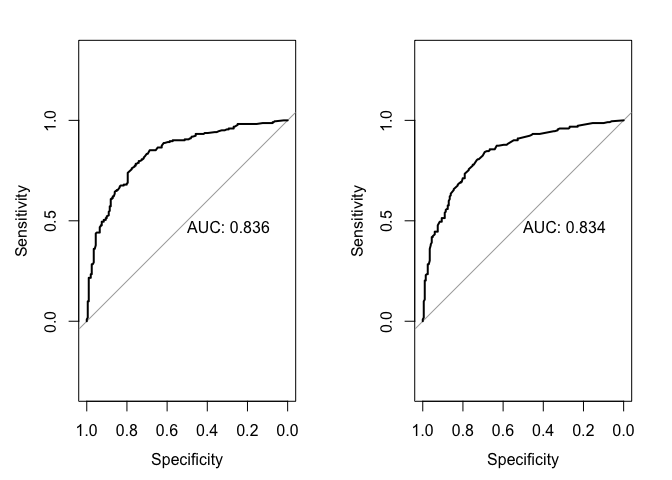

In [ ]:
par(mfrow = c(1,2))

# logistic regression model ROC
pred_test_logistic <- predict(mod_logistic, tb_test, 
                              type = "response")
roc_test_logistic <- roc(predictor = pred_test_logistic,
                     response = tb_test$tb,
                     levels = c(0,1), direction = "<")

plot(roc_test_logistic, print.auc = TRUE)


# lasso model ROC
X_test <- model.matrix(tb~., data = tb_test)[,-1]
pred_test_lasso <- as.numeric(predict(mod_lasso, newx = X_test, 
                                 type = "response"))
roc_test_lasso <- roc(predictor = pred_test_lasso,
                     response = tb_test$tb,
                     levels = c(0,1), direction = "<")

plot(roc_test_lasso, print.auc = TRUE)

We refit the lasso model on the full data from South Africa and present
the updated model in the subsequent code chunk.

In [ ]:
# fit lasso model with CV
X_train_full <- model.matrix(tb~., data = tb_southafrica)[, -1]
y_train_full <- tb_southafrica[,1]
mod_cv_full <- cv.glmnet(X_train_full, y_train_full, alpha = 1, 
                       family = "binomial", nfolds = 5)

# refit for given lambda
mod_full <- glmnet(X_train_full, y_train_full, alpha = 1, 
                   family = "binomial", 
                   lambda = mod_cv_full$lambda.min)

# create data frame
coef_df <- data.frame(
  Variable = c("Intercept", colnames(X_train_full)),
  Lasso = signif(exp(as.numeric(coef(mod_full))), 3))
coef_df

           Variable   Lasso
1         Intercept  0.0545
2  age_group[15,25)  1.3400
3  age_group[25,35)  2.5500
4  age_group[35,45)  1.8000
5  age_group[45,55)  1.2300
6          hiv_pos1  2.5900
7         diabetes1  1.9300
8       ever_smoke1  0.7750
9          past_tb1  1.2200
10            male1  2.5000
11         hs_less1  1.2400
12  two_weeks_symp1  2.5200
13    num_symptoms2  1.8700
14    num_symptoms3  5.9400
15    num_symptoms4 10.2000

## Evaluate Model on Validation Data  

We then evaluate the lasso model on the withheld validation data. This
data comes from clinics in urban Uganda and contains only 387
observations. The generated table shows that this population differs
from our training population including having a lower proportion of
patients diagnosed with TB.

In [ ]:
tbl_summary(tb_diagnosis, by = c(country),
            label = list(tb ~ "TB Diagnosis",
                         age_group ~ "Age",
                         hiv_pos ~ "HIV Positive",
                         diabetes ~ "Diabetes",
                         ever_smoke ~ "Ever Smoked",
                         past_tb ~ "Past TB Diagnosis",
                         male ~ "Male",
                         hs_less ~ "< HS Education",
                         two_weeks_symp ~ "Symptoms for Two Weeks",
                         num_symptoms ~ "Number of TB Symptoms")) %>%
  modify_spanning_header(c("stat_1", "stat_2") ~ "**Country**") %>%
  as_gt()

The ROC curve shows that the AUC on the validation data is lower than on
the training data but still maintains meaningful discrimination.

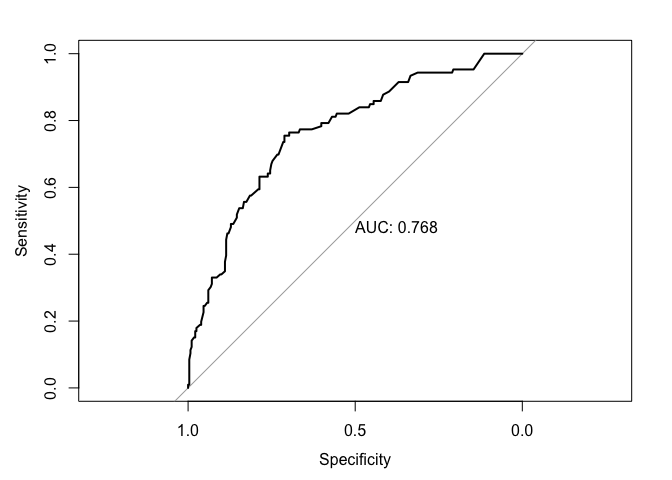

In [ ]:
# lasso validation roc
X_val <- model.matrix(tb~., data = tb_uganda)[, -1]
pred_val <- as.numeric(predict(mod_full, newx = X_val, 
                                      type = "response"))
roc_val_lasso <- roc(predictor = pred_val,
                     response = tb_uganda$tb,
                     levels = c(0,1), direction = "<")

plot(roc_val_lasso, print.auc = TRUE)